In [1]:
%pylab inline
from astropy.io import fits
import astropy.constants as const
from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u
from tools.flux_calculator import calc_fluxes, make_rotation_diagram
from tools.flux_calculator.helpers import extract_hitran_data, extract_vup, strip_superfluous_hitran_data, \
                                          line_fit, fwhm_to_sigma, calc_linewidth
from tools.spec_utils import vgeo, vproj, vlsr_to_vhelio

Populating the interactive namespace from numpy and matplotlib


In [2]:
hdulist20110620=fits.open('./gluedata/GQ_Lup/absorption_corrected/abs_corr_GQLUP_20110620_glue.fits')
hdulist20120512=fits.open('./gluedata/GQ_Lup/absorption_corrected/abs_corr_GQLUP_20120512_glue.fits')
hdulist20120702=fits.open('./gluedata/GQ_Lup/absorption_corrected/abs_corr_GQLUP_20120702_glue.fits')
hdulist20130624=fits.open('./gluedata/GQ_Lup/absorption_corrected/abs_corr_GQLUP_20130624_glue.fits')

data20110620=hdulist20110620[1].data
data20120512=hdulist20120512[1].data
data20120702=hdulist20120702[1].data
data20130624=hdulist20130624[1].data

In [3]:
def waveShift(vdop, wave):
    return vdop*1e9*wave/(const.c.to('micron/s').value)

#######################################################################

# VGEO Doppler Shift variables

mycoord=SkyCoord('16h11m31.35s', '-18d38m25.96s', frame='icrs')
mydate20110620=Time('2011-06-20T00:00:00.0', format='isot', scale='utc')
mydate20120512=Time('2012-05-12T00:00:00.0', format='isot', scale='utc')
mydate20120702=Time('2012-07-02T00:00:00.0', format='isot', scale='utc')
mydate20130624=Time('2013-06-24T00:00:00.0', format='isot', scale='utc')
vhelio = vlsr_to_vhelio(mycoord, 4.29) #VLSR of 4.5 km/s according to Salyk et al. 2014

#VGEO Doppler Shift Correction

vgeo20110620 = data20110620['wave'] + waveShift(-vgeo(mydate20110620,mycoord,vhel=vhelio), data20110620['wave'])
vgeo20120512 = data20120512['wave'] + waveShift(-vgeo(mydate20120512,mycoord,vhel=vhelio), data20120512['wave'])
vgeo20120702 = data20120702['wave'] + waveShift(-vgeo(mydate20120702,mycoord,vhel=vhelio), data20120702['wave'])
vgeo20130624 = data20130624['wave'] + waveShift(-vgeo(mydate20130624,mycoord,vhel=vhelio), data20130624['wave'])

#######################################################################

# Hand-Picked Shifts

vdop20110620 = 3 #km/s
vdop20120512 = -18 #km/s
vdop20120702 = -32 #km/s
vdop20130624 = -32 #km/s

data20110620['wave'] += waveShift(vdop20110620, data20110620['wave'])
data20120512['wave'] += waveShift(vdop20120512, data20120512['wave'])
data20120702['wave'] += waveShift(vdop20120702, data20120702['wave'])
data20130624['wave'] += waveShift(vdop20130624, data20130624['wave'])

# data20110620['wave'] = vgeo20110620
# data20120512['wave'] = vgeo20120512
# data20120702['wave'] = vgeo20120702
# data20130624['wave'] = vgeo20130624

In [4]:
#######################################################################

# Creating hitran data tables

out_all12 = extract_hitran_data('CO', 4.648, 5.018)
out_all13 = extract_hitran_data('CO', 4.648, 5.018, isotopologue_number=2)
hitran12CO1_0 = extract_vup(out_all12,1)
hitran12CO2_1 = extract_vup(out_all12,2)

#######################################################################

del(hitran12CO1_0[:2])
del(hitran12CO1_0[3:])

print(np.shape(hitran12CO1_0))

(3,)


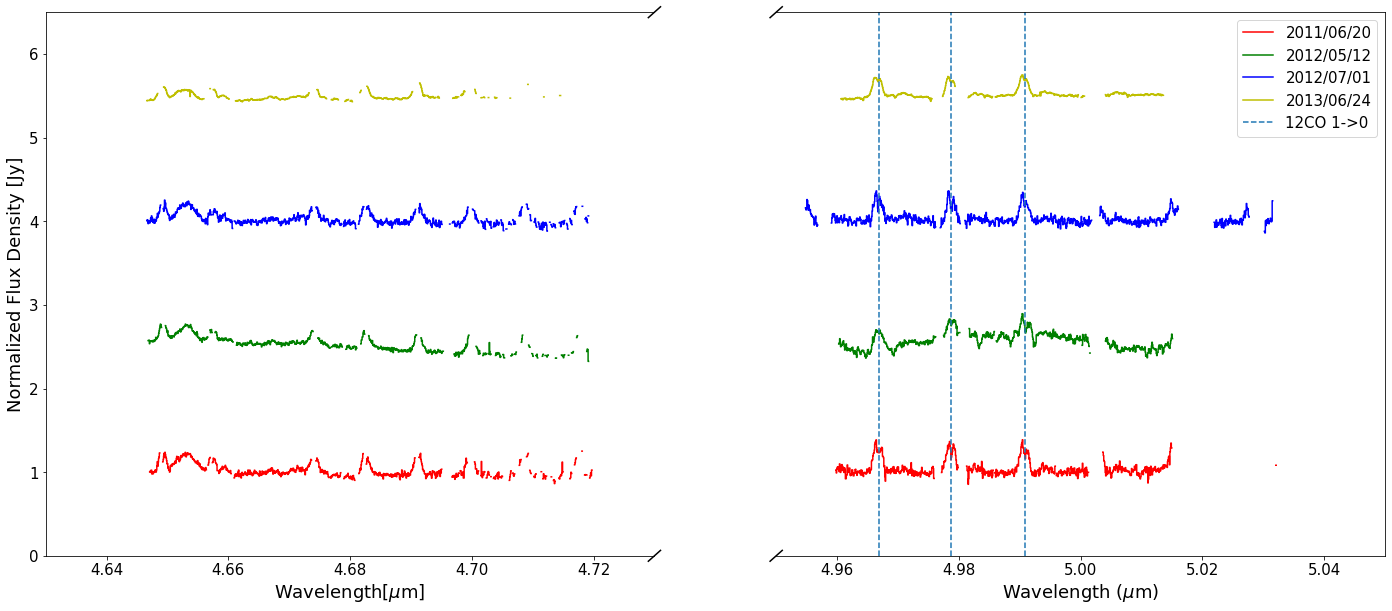

In [5]:
#######################################################################

# Preparing plot

fig=plt.figure(figsize=(24,10))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

#######################################################################

# Plotting data

ax1.plot(data20110620['wave'], data20110620['div'], drawstyle='steps-mid', color='r')
ax1.plot(data20120512['wave'], data20120512['div']+1.5, drawstyle='steps-mid', color='g')
ax1.plot(data20120702['wave'], data20120702['div']+3, drawstyle='steps-mid', color='b')
ax1.plot(data20130624['wave'], data20130624['div']+4.5, drawstyle='steps-mid', color='y')

ax2.plot(data20110620['wave'], data20110620['div'], drawstyle='steps-mid', color='r', label='2011/06/20')
ax2.plot(data20120512['wave'], data20120512['div']+1.5, drawstyle='steps-mid', color='g', label='2012/05/12')
ax2.plot(data20120702['wave'], data20120702['div']+3, drawstyle='steps-mid', color='b', label='2012/07/01')
ax2.plot(data20130624['wave'], data20130624['div']+4.5, drawstyle='steps-mid', color='y', label='2013/06/24')

#######################################################################

# Plotting CO Emission Lines

for i, wave in enumerate(hitran12CO1_0['wave']):
    if(wave<4.8):
        ax1.axvline(wave, 0,30, linestyle='--')
        #ax1.text(wave-0.001, 8, i)
    else:
        ax2.axvline(wave, 0,30, linestyle='--')
        #ax2.text(wave-0.001, 8, hitran12CO1_0['Qpp'][i])

# for i, wave in enumerate(hitran12CO2_1['wave']):
#     if(wave<4.8):
#         ax1.axvline(wave, 0,30, linestyle='-.')
#         ax1.text(wave-0.001, 8, hitran12CO2_1['Qpp'][i])
#     else:
#         ax2.axvline(wave, 0,30, linestyle='-.')
#         ax2.text(wave-0.001, 8, hitran12CO2_1['Qpp'][i])

# Labeling Emission Lines

ax2.axvline(0,0,0, linestyle='--', label='12CO 1->0')
# ax2.axvline(0,0,0, linestyle='-.', label='12CO 2->1')

#######################################################################

# Configuration of split x axis

# Tick marks signifying broken axis
g = .01
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-g,1+g), (-g,+g), **kwargs)
ax1.plot((1-g,1+g),(1-g,1+g), **kwargs)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-g,+g), (1-g,1+g), **kwargs)
ax2.plot((-g,+g), (-g,+g), **kwargs)

# Hiding axes and values on those axes
ax2.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.yaxis.set_visible(False)
#######################################################################

# Plot Formatting
ax1.set_xlabel('Wavelength[$\mu$m]', fontsize=18)
ax2.set_xlabel('Wavelength ($\mu$m)', fontsize=18)
ax1.set_ylabel('Normalized Flux Density [Jy]', fontsize=18)
ax2.legend(loc=1, prop={'size': 15})
ax1.set_xlim(4.63, 4.73)
ax2.set_xlim(4.95, 5.05)
ax1.set_ylim(0,6.5)
ax2.set_ylim(0,6.5)
ax1.tick_params(axis='x', labelsize=15 )
ax1.tick_params(axis='y', labelsize=15 )
ax2.tick_params(axis='x', labelsize=15 )


In [6]:
def graph_emission_line(hitranData, observations, dates, src, fitLines=False, km=True):
    
    fig=plt.figure(figsize(10,5))
    ax=fig.add_subplot(111)
    
    def waveToKM(myLambda, DLambda):
        vel = DLambda*const.c.to('km/s').value/ myLambda
        return vel
    
#######################################################################

    # For each date of observations, graph emission line
    for i in arange(dates.size):
        myBool = (observations[i]['wave'] > hitranData['wave']-0.003) & (observations[i]['wave'] < hitranData['wave']+0.003)
        wave=observations[i]['wave'][myBool]
        div=observations[i]['div'][myBool]
        k_m = waveToKM(hitranData['wave'], wave-hitranData['wave'])
        
#######################################################################

        # Plotting with x-axis in km/s
        if km:
            ax.plot(k_m, div, drawstyle='steps-mid', label=dates[i])
            ax.set_xlabel('km/s', fontsize=12)
            axvline(0, 0,2, linestyle='--')
            ax.set_xlim(-100, 100)
#######################################################################

            # fitLines will plot a line fit, and illustrate FWHM on emission line profile
            if fitLines:
                fit = line_fit(wave, div, nterms=4, p0=[0.1, hitranData['wave'], fwhm_to_sigma(20*1e3/const.c.value*hitranData['wave']), 1])
                ax.plot(k_m, fit['yfit'], label=dates[i]+' Fit')
                waveMax = k_m[np.argmax(fit['yfit'])]
                (fwhm, fwhm_err) = calc_linewidth(fit['parameters'], fit['parameter_errors'])
                x=arange(waveMax-fwhm.value/2, waveMax+fwhm.value/2, 0.1)
                ax.plot(x, np.full(x.size, np.max(fit['yfit'])-(np.max(fit['yfit'])-fit['parameters'][3])/2), label=dates[i]+' FWHM')
                a
#######################################################################

        # Plotting with wavelength on x-axis
        else:
            ax.plot(wave,div,drawstyle='steps-mid', label=dates[i])
            ax.set_xlim(hitranData['wave']-0.003, hitranData['wave']+0.003)
            ax.set_xlabel('Wavelength [$\mu$m]', fontsize=12)
            axvline(hitranData['wave'], 0, 2, linestyle='--')
            if fitLines:
                fit = line_fit(wave, div, nterms=4, p0=[0.1, hitranData['wave'], fwhm_to_sigma(20*1e3/const.c.value*hitranData['wave']), 1])
                ax.plot(wave, fit['yfit'], label=dates[i]+' Fit')
                
#######################################################################
        
    # Plotting hitran emisssion line
    ax.axvline(0,0,0,linestyle='--', label=hitranData['Qpp'])
    
    if(hitranData['local_iso_id']==1):
        isotope = '12CO'
    elif(hitranData['local_iso_id']==2):
        isotope = '13CO'
        
    if(np.int(hitranData['Vp'])==1):
        trans= 'v=1-0'
    elif(np.int(hitranData['Vp'])==2):
        trans= 'v=2-1'
        
    pNum = hitranData['Qpp']
    title = 'Lineprofile for '+isotope+' '+trans+pNum+' Emission line from '+src
    
    # Setting title and axes labels
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Normalized Flux Density [Jy]', fontsize=12)
    ax.legend()
    

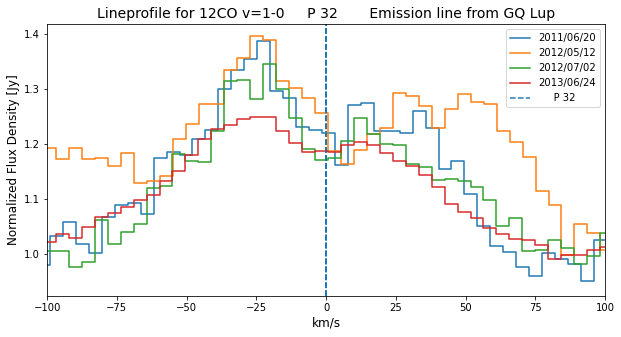

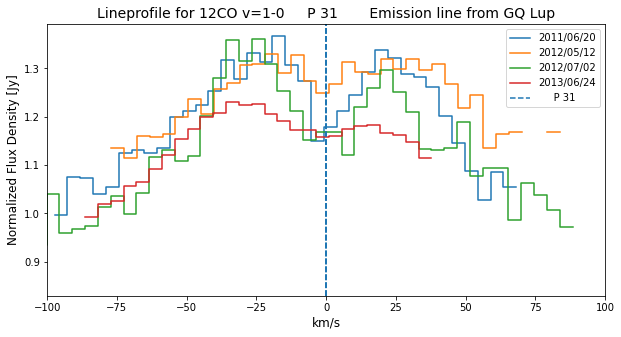

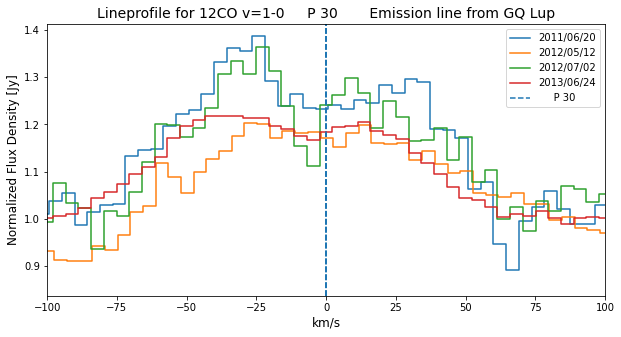

In [7]:
obs = np.array([data20110620, data20120512, data20120702, data20130624])
dates = np.array(['2011/06/20', '2012/05/12', '2012/07/02', '2013/06/24'])

graph_emission_line(hitran12CO1_0[0], obs, dates, 'GQ Lup')
graph_emission_line(hitran12CO1_0[1], obs, dates, 'GQ Lup')
graph_emission_line(hitran12CO1_0[2], obs, dates, 'GQ Lup')

In [ ]:
t1=calc_fluxes(data20110620['wave'],data20110620['div'],hitran12CO1_0, sep_v = 100, vet_fits=True)
#t2=calc_fluxes(data20120512['wave'],data20120512['div'],hitran12CO1_0, sep_v = 100, vet_fits=True)
#t3=calc_fluxes(data20120702['wave'],data20120702['div'],hitran12CO1_0, sep_v = 100, vet_fits=True)
#t4=calc_fluxes(data20130624['wave'],data20130624['div'],hitran12CO1_0, sep_v = 100, vet_fits=True)

/Users/adammoses/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: Mean of empty slice


(-125.0, 125.0)

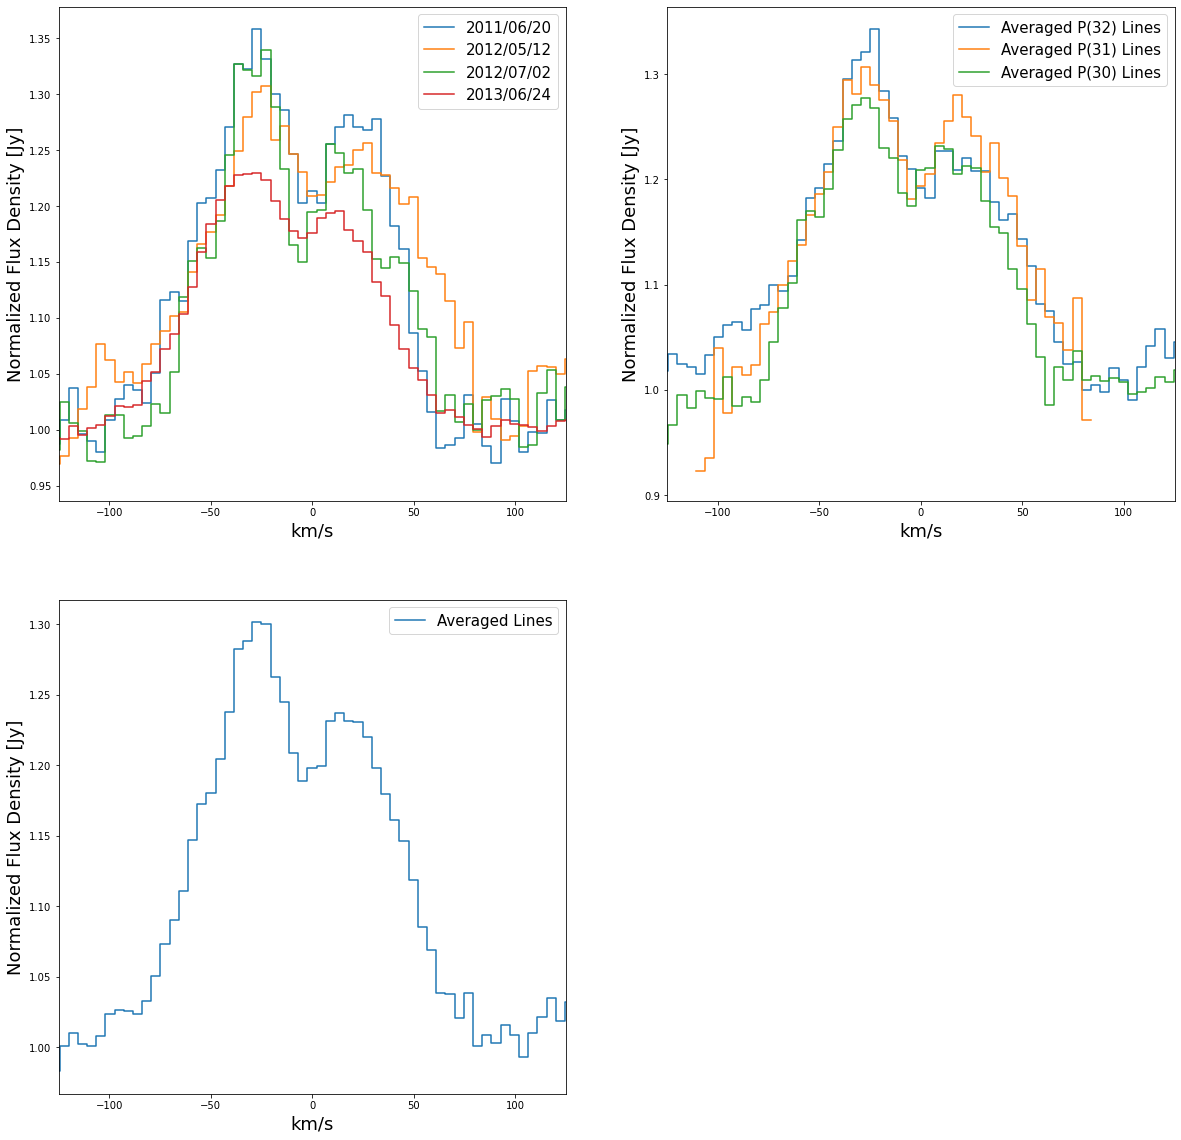

In [9]:
def waveToKM(myLambda, DLambda):
    vel = DLambda*const.c.to('km/s').value/ myLambda
    return vel

######################################################################
    
myBool = (data20110620['wave'] > hitran12CO1_0[0]['wave']-0.003) & (data20110620['wave'] < hitran12CO1_0[0]['wave']+0.003)
div20110620_0=data20110620['div'][myBool]
k_m = waveToKM(hitran12CO1_0[0]['wave'], data20110620['wave'][myBool]-hitran12CO1_0[0]['wave'])

myBool = (data20110620['wave'] > hitran12CO1_0[1]['wave']-0.00295) & (data20110620['wave'] < hitran12CO1_0[1]['wave']+0.00295)
div20110620_1=data20110620['div'][myBool]
k_m = waveToKM(hitran12CO1_0[0]['wave'], data20110620['wave'][myBool]-hitran12CO1_0[1]['wave'])

myBool = (data20110620['wave'] > hitran12CO1_0[2]['wave']-0.00295) & (data20110620['wave'] < hitran12CO1_0[2]['wave']+0.00295)
div20110620_2=data20110620['div'][myBool]
k_m = waveToKM(hitran12CO1_0[0]['wave'], data20110620['wave'][myBool]-hitran12CO1_0[2]['wave'])

ave20110620 = nanmean(np.array([div20110620_0, div20110620_1, div20110620_2]), axis=0)

######################################################################

myBool = (data20120512['wave'] > hitran12CO1_0[0]['wave']-0.003) & (data20120512['wave'] < hitran12CO1_0[0]['wave']+0.003)
div20120512_0=data20120512['div'][myBool]
k_m = waveToKM(hitran12CO1_0[0]['wave'], data20120512['wave'][myBool]-hitran12CO1_0[0]['wave'])

myBool = (data20120512['wave'] > hitran12CO1_0[1]['wave']-0.00298) & (data20120512['wave'] < hitran12CO1_0[1]['wave']+0.00298)
div20120512_1=data20120512['div'][myBool]
k_m = waveToKM(hitran12CO1_0[0]['wave'], data20120512['wave'][myBool]-hitran12CO1_0[1]['wave'])

myBool = (data20120512['wave'] > hitran12CO1_0[2]['wave']-0.00294) & (data20120512['wave'] < hitran12CO1_0[2]['wave']+0.00294)
div20120512_2=data20120512['div'][myBool]
k_m = waveToKM(hitran12CO1_0[0]['wave'], data20120512['wave'][myBool]-hitran12CO1_0[2]['wave'])

ave20120512 = nanmean(np.array([div20120512_0, div20120512_1, div20120512_2]), axis=0)

######################################################################

myBool = (data20120702['wave'] > hitran12CO1_0[0]['wave']-0.003) & (data20120702['wave'] < hitran12CO1_0[0]['wave']+0.003)
div20120702_0=data20120702['div'][myBool]
k_m = waveToKM(hitran12CO1_0[0]['wave'], data20120702['wave'][myBool]-hitran12CO1_0[0]['wave'])

myBool = (data20120702['wave'] > hitran12CO1_0[1]['wave']-0.00298) & (data20120702['wave'] < hitran12CO1_0[1]['wave']+0.00298)
div20120702_1=data20120702['div'][myBool]
k_m = waveToKM(hitran12CO1_0[0]['wave'], data20120702['wave'][myBool]-hitran12CO1_0[1]['wave'])

myBool = (data20120702['wave'] > hitran12CO1_0[2]['wave']-0.00294) & (data20120702['wave'] < hitran12CO1_0[2]['wave']+0.00294)
div20120702_2=data20120702['div'][myBool]
k_m = waveToKM(hitran12CO1_0[0]['wave'], data20120702['wave'][myBool]-hitran12CO1_0[2]['wave'])

ave20120702 = nanmean(np.array([div20120702_0, div20120702_1, div20120702_2]), axis=0)

######################################################################

myBool = (data20130624['wave'] > hitran12CO1_0[0]['wave']-0.003) & (data20130624['wave'] < hitran12CO1_0[0]['wave']+0.003)
div20130624_0=data20130624['div'][myBool]
k_m = waveToKM(hitran12CO1_0[0]['wave'], data20130624['wave'][myBool]-hitran12CO1_0[0]['wave'])

myBool = (data20130624['wave'] > hitran12CO1_0[1]['wave']-0.00298) & (data20130624['wave'] < hitran12CO1_0[1]['wave']+0.00298)
div20130624_1=data20130624['div'][myBool]
k_m = waveToKM(hitran12CO1_0[0]['wave'], data20130624['wave'][myBool]-hitran12CO1_0[1]['wave'])

myBool = (data20130624['wave'] > hitran12CO1_0[2]['wave']-0.00294) & (data20130624['wave'] < hitran12CO1_0[2]['wave']+0.00294)
div20130624_2=data20130624['div'][myBool]
k_m = waveToKM(hitran12CO1_0[0]['wave'], data20130624['wave'][myBool]-hitran12CO1_0[2]['wave'])

ave20130624 = nanmean(np.array([div20130624_0, div20130624_1, div20130624_2]), axis=0)

######################################################################

ave_0 = nanmean(np.array([div20110620_0, div20120512_0, div20120702_0, div20130624_0]), axis=0)
ave_1 = nanmean(np.array([div20110620_1, div20120512_1, div20120702_1, div20130624_1]), axis=0)
ave_2 = nanmean(np.array([div20110620_2, div20120512_2, div20120702_2, div20130624_2]), axis=0)

######################################################################

avelines = nanmean(np.array([ave20110620,ave20120512,ave20120702,ave20130624]), axis=0)

fig=plt.figure(figsize=(20,20))
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)
ax3=fig.add_subplot(223)


ax1.plot(k_m, ave20110620, drawstyle='steps-mid', label='2011/06/20')
ax1.plot(k_m, ave20120512, drawstyle='steps-mid', label='2012/05/12')
ax1.plot(k_m, ave20120702, drawstyle='steps-mid', label='2012/07/02')
ax1.plot(k_m, ave20130624, drawstyle='steps-mid', label='2013/06/24')

ax2.plot(k_m, ave_0, drawstyle='steps-mid', label='Averaged P(32) Lines')
ax2.plot(k_m, ave_1, drawstyle='steps-mid', label='Averaged P(31) Lines')
ax2.plot(k_m, ave_2, drawstyle='steps-mid', label='Averaged P(30) Lines')

ax3.plot(k_m, avelines, drawstyle='steps-mid', label='Averaged Lines')

ax1.set_xlabel('km/s', fontsize=18)
ax1.set_ylabel('Normalized Flux Density [Jy]', fontsize=18)
ax2.set_xlabel('km/s', fontsize=18)
ax2.set_ylabel('Normalized Flux Density [Jy]', fontsize=18)
ax3.set_xlabel('km/s', fontsize=18)
ax3.set_ylabel('Normalized Flux Density [Jy]', fontsize=18)

ax1.legend(loc=1, prop={'size': 15})
ax2.legend(loc=1, prop={'size': 15})
ax3.legend(loc=1, prop={'size': 15})

ax1.set_xlim(-125, 125)
ax2.set_xlim(-125, 125)
ax3.set_xlim(-125, 125)



In [10]:
(29+32+2384+np.nan)/2

nan